In [1]:
%load_ext autoreload
%autoreload 2


import sys, os, pickle, h5py
import numpy as np
from scipy.stats import norm
from scipy import stats, optimize, ndimage, signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
import copy

##############
#For plotting
import matplotlib.cm as cm

from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = False#True
#rcParams['text.latex.unicode'] = True
#rcParams['text.fontsize'] = 18


print("starting the python script!")

########################
kev_to_erg = 1.60218e-9

os.sys.path.append("../python")
#import plotting
import copy
from scipy.interpolate import interp1d

from scipy.optimize import minimize
sys.path.append("/clusterfs/heptheory/brsafdi/brsafdi/transfer/bsafdi/github/gmf") #"/global/cfs/cdirs/m3166/bsafdi/gmf")
import gmf
import pygedm
import healpy as hp
#data_dir = "/nfs/turbo/bsafdi/bsafdi/github/SSCaxion/data/"

starting the python script!


# Methods

## Methods related to the magnetic field profile

In [2]:
# Different B-field models
GMF0=gmf.GMF()
GMFP = gmf.GMF_Pshirkov(mode="ASS") #BSS")
def arctanM(x,y):
    tmp = np.arctan2(x,y)
    if tmp<0:
        res= 2*np.pi+tmp
    else:
        res = tmp
    return res

def B_GMF(x_vec):
    '''
    x_vec in pc, origin at GC and x_vec = [-8.5,0.0,0.0] Sun (check!!)
    '''
    x,y,z = x_vec*1e-3
    rho = np.sqrt(x**2+y**2)
    phi = arctanM(y,x)
    rho_hat = np.array([x,y,0.0])/rho
    phi_hat = np.array([-y,x,0.0])/rho
    z_hat = np.array([0.0,0.0,1.0])
    
    disk,_ = GMF0.Bdisk(np.array([rho]),np.array([phi]),np.array([z]))
    halo,_ = GMF0.Bhalo(np.array([rho]),np.array([z]))
    Bx,_ = GMF0.BX(np.array([rho]),np.array([z]))
    
    Btot = rho_hat*(disk[0]+halo[0]+Bx[0])+phi_hat*(disk[1]+halo[1]+Bx[1])+z_hat*(disk[2]+halo[2]+Bx[2])
    return Btot


def B_Psh(x_vec):
    '''
    x_vec in pc, origin at GC and x_vec = [-8.5,0.0,0.0] Sun (check!!)
    '''
    x,y,z = x_vec*1e-3
    rho = np.sqrt(x**2+y**2)
    phi = arctanM(y,x)
    rho_hat = np.array([x,y,0.0])/rho
    phi_hat = np.array([-y,x,0.0])/rho
    z_hat = np.array([0.0,0.0,1.0])
    
    disk,_ = GMFP.Bdisk(np.array([rho]),np.array([phi]),np.array([z]))
    halo,_ = GMFP.Bhalo(np.array([rho]),np.array([z]))
    
    Btot = rho_hat*(disk[0]+halo[0])+phi_hat*(disk[1]+halo[1])+z_hat*(disk[2]+halo[2])
    return Btot


## Methods related to the magnetic field geometry for axion conversion (given LOS)

In [3]:
class conversion:
    def __init__(self,xf,Bfunc,xi=np.array([-8.5e3,0.0,0.00])):
        #see https://arxiv.org/pdf/1704.05063.pdf for height
        # consider later using Zi = 0.025, for example
        self._xf = xf
        self._xi = xi
        self._compute_geometry()
        self._Bfunc = Bfunc
    
    def _compute_geometry(self):
        rvec = self._xf - self._xi
        self._d = np.linalg.norm(rvec)
        self._rhat = rvec/self._d
        
        if self._rhat[2]>0:
            N = self._rhat
        else:
            N = - self._rhat
        
        r1 = N[0]
        r2 = N[1]
        self._k1 = 1/np.sqrt(1-r2**2)*np.array([-np.sqrt(1-r1**2-r2**2),0,r1])
        self._k2 = np.sqrt(1-r2**2)*np.array([-r1*r2/(1-r2**2),1,-r2*np.sqrt(1-r1**2-r2**2)/(1-r2**2)])

    def _return_x(self,r):
        '''
        r in pc and is distance from the Sun
        '''
        rkpc = r #*1e-3
        x = self._xi + rkpc*self._rhat
        return x
    
    def _return_Bs(self,r):
        '''
        r in pc and is distance from the Sun
        '''
        rkpc = r #*1e-3
        x = self._xi + rkpc*self._rhat
        Bf = self._Bfunc(x)
        return np.dot(Bf,self._k1), np.dot(Bf,self._k2)

## The method that computes the conversion probability

In [4]:
import numpy as np
from scipy.integrate import cumtrapz

def return_prob(z_array,B_x,B_y,m_a=1e-15,E=10.0,g_agg = 1e-12,**kwargs):
    '''
    return_prob: Axion-photon conversion probability calculation as given in https://arxiv.org/pdf/1903.05088.pdf Eq. (5).
    
    Input:
    ----
    z_array: units [pc].  array of z-values going from the source to the Earth.
    B_x, B_y: units [\mu G]. arrays of the othogonal components of the magnetic field at the z values corresponding to z_array
    m_a: units [eV]. mass of the axion.
    g_agg: units [GeV^{-1}]. axion-photon coupling constant
    E: energy of axion in keV
    n_e: units [cm^{-3}]. free electron density at z values in z_array.  if empty then set to zero
    
    Returns
    ----
    prob: unitless, axion-photon conversion probability 
    '''
    
    ## First we check to see if an array of `n_e` values was given
    if 'n_e' in kwargs.keys():
        n_e = kwargs['n_e']
    else:
        n_e = np.zeros(len(z_array)) #else set to zeros
        
    ## Here we precompute some useful things
    omega_pl = 1.19e-12*np.sqrt((n_e/1e-3)) #$\omega_{pl}$ [units of eV]
    Delta_parr = -0.0781*(omega_pl/1e-10)**2/(E/10.0) # $\Delta_{||}$ [units of pc^{-1}]
    axion_mass_factor = -0.0781*(m_a/1e-10)**2 /(E/10.0) #$\Delta_a$ [units pc^{-1}]
    norm_factor =(g_agg/1e-12)**2*8.8e12*(1e-12)**2/4. #units conversion factor that accounts for g_agg [dimensionless]
    Delta_parr_int = cumtrapz(Delta_parr,z_array) #The integral of $\Delta_{||}$ appearing in exponential of Eq. 5 [dimensionless]
    z_centers = (z_array[1:]+z_array[:-1])/2. #We have to integrate twice, so going to downbin the z_array once
    B_x_centers = (B_x[1:]+B_x[:-1])/2. #down-binned B_x's
    B_y_centers = (B_y[1:]+B_y[:-1])/2. #down-binned B_y's
    
    prob_x_integrand = B_x_centers*np.exp(1j*axion_mass_factor*z_centers -1j*Delta_parr_int ) #The B_x part of the integral
    prob_y_integrand = B_y_centers*np.exp(1j*axion_mass_factor*z_centers -1j*Delta_parr_int ) #The B_y part of integral
    prob_x_complex = np.trapz(prob_x_integrand,z_centers) #Do the integral
    prob_y_complex = np.trapz(prob_y_integrand,z_centers) #Do the integral
    
    # Below, we apply the normalization and compute the conversion probability.  The np.real is just there to convert back to real number type
    prob =  np.real(norm_factor*(prob_x_complex*np.conj(prob_x_complex)+prob_y_complex*np.conj(prob_y_complex)))
    return prob

## The main class

This compute the conversion probability given and $\ell$ and a $b$. `n_prec` is a precision factor for the numerical integration, and `dist` controls the distance out to which you integrate. `prob_masses` is an array in eV of the axion masses to consider, and `prob_energies` are the energies in keV to compute the conversion probabilities over.

In [5]:
class make_conv_map:
    def __init__(self,prob_masses,prob_energies,ell,b,n_prec = 500,x_sun = -8.5,dist=50):
        '''
        ell, b in degrees
        disk: kpc, distance out to integrate
        x_sun: x-coordinate of the Sun in kpc
        '''
        self._prob_masses = prob_masses
        self._prob_energies = prob_energies
        self._ell = ell*np.pi/180. #radians
        self._b = b*np.pi/180. #radians
        self._n_prec = n_prec
        self._x_sun = x_sun
        self._d = dist
        self._make_vecs()
        self._do_conv_prob()
        
    def _make_vecs(self):
        '''
        compute the coordinates of the target in Galactic coordinates centered at the GC
        '''
        x = 1e3*(self._x_sun+self._d*np.cos(self._b)*np.cos(self._ell))
        y = 1e3*(self._d*np.cos(self._b)*np.sin(self._ell))
        z = 1e3*(self._d*np.sin(self._b))
        xvec= np.array([x,y,z]) #in pc
        #print(xvec)
        
        # now do B-field
        cv = conversion(xvec,B_GMF,xi=np.array([self._x_sun*1e3,0.0,0.00]))
        z_vec = np.linspace(0,cv._d,self._n_prec)
        B1_array = np.zeros(len(z_vec))
        B2_array = np.zeros(len(z_vec))
        for i in range(len(z_vec)):
            z = z_vec[i]
            B1,B2 = cv._return_Bs(z)
            B1_array[i] = B1
            B2_array[i] = B2
            
        self._z_vec = z_vec
        self._B1_array = B1_array
        self._B2_array = B2_array
        
        # now do ne-profile
        Rsun_16 = 8.3e3
        ne_arr = np.zeros(len(z_vec))
        #ne_arr_2001_GC = np.zeros(len(z_vec_GC))
        #ne_arr_2020_GC = np.zeros(len(z_vec_GC))
        z_vec_16 = np.linspace(0,cv._d/(np.abs(self._x_sun)*1e3)*Rsun_16,self._n_prec)
        for i in range(len(ne_arr)):
            x = cv._return_x(z_vec_16[i])+np.array([-Rsun_16+np.abs(self._x_sun)*1e3,0,0])
            x_coppy = np.zeros(np.shape(x))
            x_coppy[0] = +x[1]
            x_coppy[1] = -x[0]
            x_coppy[2] = x[2]
            #print x
            ne_arr[i] = pygedm.calculate_electron_density_xyz(x_coppy[0],x_coppy[1],x_coppy[2]).value
        
        self._ne_arr = ne_arr
        
    def _do_conv_prob(self):
        self.conv_probs = np.zeros((len(self._prob_masses),len(self._prob_energies)))
        for i in range(len(self._prob_masses)):
            for j in range(len(self._prob_energies)):
                self.conv_probs[i,j] = return_prob(self._z_vec,self._B1_array,self._B2_array,E=self._prob_energies[j],m_a=self._prob_masses[i], n_e=self._ne_arr) 


### Run an example

In [6]:
prob_masses = np.geomspace(1e-13, 1e-9, 2) # axion masses in eV
prob_energies = np.linspace(1.0, 10.0, 2) # axion energies in keV

nside=8
npix = hp.nside2npix(nside)
res_array = np.zeros((len(prob_masses),len(prob_energies),npix))
for i in range(npix):
    print("i = ",i," of ", npix)
    print("frac done is ", i / float(npix))
    theta,phi = hp.pix2ang(nside,i) #theta,phi in rad
    ell = phi*180./np.pi
    b = (np.pi/2.-theta)*180./np.pi
    mcp = make_conv_map(prob_masses,prob_energies,ell,b)
    res_array[::,::,i] =mcp.conv_probs #make_conv_map(prob_masses,prob_energies,ell,b)
    



i =  0  of  768
frac done is  0.0
i =  1  of  768
frac done is  0.0013020833333333333
i =  2  of  768
frac done is  0.0026041666666666665
i =  3  of  768
frac done is  0.00390625
i =  4  of  768
frac done is  0.005208333333333333
i =  5  of  768
frac done is  0.006510416666666667
i =  6  of  768
frac done is  0.0078125
i =  7  of  768
frac done is  0.009114583333333334
i =  8  of  768
frac done is  0.010416666666666666
i =  9  of  768
frac done is  0.01171875
i =  10  of  768
frac done is  0.013020833333333334
i =  11  of  768
frac done is  0.014322916666666666
i =  12  of  768
frac done is  0.015625
i =  13  of  768
frac done is  0.016927083333333332
i =  14  of  768
frac done is  0.018229166666666668
i =  15  of  768
frac done is  0.01953125
i =  16  of  768
frac done is  0.020833333333333332
i =  17  of  768
frac done is  0.022135416666666668
i =  18  of  768
frac done is  0.0234375
i =  19  of  768
frac done is  0.024739583333333332
i =  20  of  768
frac done is  0.0260416666666666

i =  171  of  768
frac done is  0.22265625
i =  172  of  768
frac done is  0.22395833333333334
i =  173  of  768
frac done is  0.22526041666666666
i =  174  of  768
frac done is  0.2265625
i =  175  of  768
frac done is  0.22786458333333334
i =  176  of  768
frac done is  0.22916666666666666
i =  177  of  768
frac done is  0.23046875
i =  178  of  768
frac done is  0.23177083333333334
i =  179  of  768
frac done is  0.23307291666666666
i =  180  of  768
frac done is  0.234375
i =  181  of  768
frac done is  0.23567708333333334
i =  182  of  768
frac done is  0.23697916666666666
i =  183  of  768
frac done is  0.23828125
i =  184  of  768
frac done is  0.23958333333333334
i =  185  of  768
frac done is  0.24088541666666666
i =  186  of  768
frac done is  0.2421875
i =  187  of  768
frac done is  0.24348958333333334
i =  188  of  768
frac done is  0.24479166666666666
i =  189  of  768
frac done is  0.24609375
i =  190  of  768
frac done is  0.24739583333333334
i =  191  of  768
frac done

i =  342  of  768
frac done is  0.4453125
i =  343  of  768
frac done is  0.4466145833333333
i =  344  of  768
frac done is  0.4479166666666667
i =  345  of  768
frac done is  0.44921875
i =  346  of  768
frac done is  0.4505208333333333
i =  347  of  768
frac done is  0.4518229166666667
i =  348  of  768
frac done is  0.453125
i =  349  of  768
frac done is  0.4544270833333333
i =  350  of  768
frac done is  0.4557291666666667
i =  351  of  768
frac done is  0.45703125
i =  352  of  768
frac done is  0.4583333333333333
i =  353  of  768
frac done is  0.4596354166666667
i =  354  of  768
frac done is  0.4609375
i =  355  of  768
frac done is  0.4622395833333333
i =  356  of  768
frac done is  0.4635416666666667
i =  357  of  768
frac done is  0.46484375
i =  358  of  768
frac done is  0.4661458333333333
i =  359  of  768
frac done is  0.4674479166666667
i =  360  of  768
frac done is  0.46875
i =  361  of  768
frac done is  0.4700520833333333
i =  362  of  768
frac done is  0.471354166

/clusterfs/heptheory/brsafdi/brsafdi/transfer/bsafdi/github/gmf/gmf.py:241: RuntimeWarning: invalid value encountered in true_divide
  tx = lambda rho,z,rho_p: np.arctan(np.abs(z)/(rho - rho_p))


i =  369  of  768
frac done is  0.48046875


/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in sqrt
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


i =  370  of  768
frac done is  0.4817708333333333
i =  371  of  768
frac done is  0.4830729166666667
i =  372  of  768
frac done is  0.484375
i =  373  of  768
frac done is  0.4856770833333333
i =  374  of  768
frac done is  0.4869791666666667
i =  375  of  768
frac done is  0.48828125
i =  376  of  768
frac done is  0.4895833333333333
i =  377  of  768
frac done is  0.4908854166666667
i =  378  of  768
frac done is  0.4921875
i =  379  of  768
frac done is  0.4934895833333333
i =  380  of  768
frac done is  0.4947916666666667
i =  381  of  768
frac done is  0.49609375
i =  382  of  768
frac done is  0.4973958333333333
i =  383  of  768
frac done is  0.4986979166666667
i =  384  of  768
frac done is  0.5
i =  385  of  768
frac done is  0.5013020833333334
i =  386  of  768
frac done is  0.5026041666666666
i =  387  of  768
frac done is  0.50390625
i =  388  of  768
frac done is  0.5052083333333334
i =  389  of  768
frac done is  0.5065104166666666
i =  390  of  768
frac done is  0.5078

i =  541  of  768
frac done is  0.7044270833333334
i =  542  of  768
frac done is  0.7057291666666666
i =  543  of  768
frac done is  0.70703125
i =  544  of  768
frac done is  0.7083333333333334
i =  545  of  768
frac done is  0.7096354166666666
i =  546  of  768
frac done is  0.7109375
i =  547  of  768
frac done is  0.7122395833333334
i =  548  of  768
frac done is  0.7135416666666666
i =  549  of  768
frac done is  0.71484375
i =  550  of  768
frac done is  0.7161458333333334
i =  551  of  768
frac done is  0.7174479166666666
i =  552  of  768
frac done is  0.71875
i =  553  of  768
frac done is  0.7200520833333334
i =  554  of  768
frac done is  0.7213541666666666
i =  555  of  768
frac done is  0.72265625
i =  556  of  768
frac done is  0.7239583333333334
i =  557  of  768
frac done is  0.7252604166666666
i =  558  of  768
frac done is  0.7265625
i =  559  of  768
frac done is  0.7278645833333334
i =  560  of  768
frac done is  0.7291666666666666
i =  561  of  768
frac done is  0

i =  712  of  768
frac done is  0.9270833333333334
i =  713  of  768
frac done is  0.9283854166666666
i =  714  of  768
frac done is  0.9296875
i =  715  of  768
frac done is  0.9309895833333334
i =  716  of  768
frac done is  0.9322916666666666
i =  717  of  768
frac done is  0.93359375
i =  718  of  768
frac done is  0.9348958333333334
i =  719  of  768
frac done is  0.9361979166666666
i =  720  of  768
frac done is  0.9375
i =  721  of  768
frac done is  0.9388020833333334
i =  722  of  768
frac done is  0.9401041666666666
i =  723  of  768
frac done is  0.94140625
i =  724  of  768
frac done is  0.9427083333333334
i =  725  of  768
frac done is  0.9440104166666666
i =  726  of  768
frac done is  0.9453125
i =  727  of  768
frac done is  0.9466145833333334
i =  728  of  768
frac done is  0.9479166666666666
i =  729  of  768
frac done is  0.94921875
i =  730  of  768
frac done is  0.9505208333333334
i =  731  of  768
frac done is  0.9518229166666666
i =  732  of  768
frac done is  0.

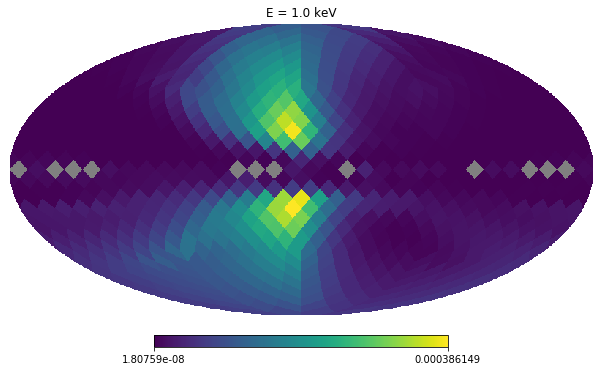

In [11]:
hp.mollview(res_array[0,0],title="E = "+ str(prob_energies[0]) + " keV")

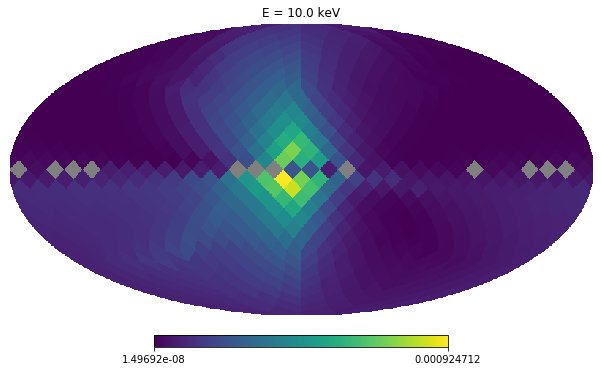

In [12]:
hp.mollview(res_array[0,-1],title="E = "+ str(prob_energies[-1]) + " keV")